<div class='bar_title'></div>

*Practical Data Science*

# From Data to Production

Matthias Griebel<br>
Chair of Information Systems and Management

Winter Semester 20/21

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Gathering-Data" data-toc-modified-id="Gathering-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Gathering Data</a></span><ul class="toc-item"><li><span><a href="#DuckDuckGo-Image-Search" data-toc-modified-id="DuckDuckGo-Image-Search-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>DuckDuckGo Image Search</a></span></li><li><span><a href="#Download-and-clean" data-toc-modified-id="Download-and-clean-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Download and clean</a></span></li></ul></li><li><span><a href="#From-Data-to-DataLoaders" data-toc-modified-id="From-Data-to-DataLoaders-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>From Data to DataLoaders</a></span><ul class="toc-item"><li><span><a href="#Data-Augmentation" data-toc-modified-id="Data-Augmentation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data Augmentation</a></span></li></ul></li><li><span><a href="#Training-Your-Model,-and-Using-It-to-Clean-Your-Data" data-toc-modified-id="Training-Your-Model,-and-Using-It-to-Clean-Your-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training Your Model, and Using It to Clean Your Data</a></span><ul class="toc-item"><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data Cleaning</a></span></li></ul></li><li><span><a href="#Turning-Your-Model-into-an-Online-Application" data-toc-modified-id="Turning-Your-Model-into-an-Online-Application-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Turning Your Model into an Online Application</a></span><ul class="toc-item"><li><span><a href="#Using-the-Model-for-Inference" data-toc-modified-id="Using-the-Model-for-Inference-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Using the Model for Inference</a></span></li><li><span><a href="#Creating-a-Notebook-App-from-the-Model" data-toc-modified-id="Creating-a-Notebook-App-from-the-Model-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Creating a Notebook App from the Model</a></span></li><li><span><a href="#Turning-Your-Notebook-into-a-Real-App" data-toc-modified-id="Turning-Your-Notebook-into-a-Real-App-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Turning Your Notebook into a Real App</a></span></li></ul></li></ul></div>

__Credits for this lecture__

<img src="https://images-na.ssl-images-amazon.com/images/I/516YvsJCS9L._SX379_BO1,204,203,200_.jpg" width="500" align="right"/>

**Jeremy Howard and Sylvian Gugger: "Deep Learning for Coders with Fastai and PyTorch: AI Applications without a PhD." (2020).**

Available as [Jupyter Notebook](https://github.com/fastai/fastbook) 

Materials taken from
- https://github.com/fastai/fastbook/blob/master/02_production.ipynb

Install and load required packages

In [ ]:
!pip install -Uqq fastai  # upgrade fastai on colab

In [18]:
from fastai.vision.all import *

## Gathering Data

**Today's project**

For many types of projects, you may be able to find all the data you need online. 
The project we'll be completing in this lecture is a **bear detector**.
It will discriminate between three types of bear: 
- grizzly bears
- black bears
- teddy bears

### DuckDuckGo Image Search

DuckDuckGo is a "privacy first" search service, with many useful features. However, they do not have an official API. Thus, we will use the `search_images_ddg` function below to get the image urls.

In [74]:
import requests
import re
import json
from fastcore.foundation import L

def search_images_ddg(key,max_n=150):
    """Search for 'key' with DuckDuckGo and return a unique urls of 'max_n' images
    (Adopted from https://github.com/deepanprabhu/duckduckgo-images-api)
    """
    url        = 'https://duckduckgo.com/'
    params     = {'q':key}
    res        = requests.post(url,data=params)
    searchObj  = re.search(r'vqd=([\d-]+)\&',res.text)
    if not searchObj: print('Token Parsing Failed !'); return
    requestUrl = url + 'i.js'
    headers    = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0',
                 'referer': 'https://duckduckgo.com/'}
    params     = (('l','us-en'),('o','json'),('q',key),('vqd',searchObj.group(1)),('f',',,,'),('p','1'),('v7exp','a'))
    urls       = []
    while True:
        try:
            res  = requests.get(requestUrl,headers=headers,params=params)
            data = json.loads(res.text)
            for obj in data['results']:
                urls.append(obj['image'])
                max_n = max_n - 1
                if max_n < 1: return L(set(urls))     # dedupe
            if 'next' not in data: return L(set(urls))
            requestUrl = url + data['next']
        except:
            pass

Searching for 'grizzly bear'

In [75]:
ims = search_images_ddg('grizzly bear')
len(ims)

132

We've successfully downloaded the URLs of about 150 grizzly bears (or, at least, images that DuckDuckGo finds for that search term). Let's look at one:

In [76]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

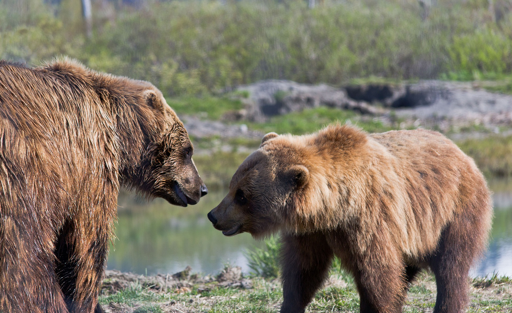

In [77]:
im = Image.open(dest)
im.to_thumb(512,512)

### Download and clean

Now let's use fastai's `download_images` to download all the URLs for each of our search terms. We'll put each in a separate folder:

In [90]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [91]:
if not path.exists(): path.mkdir()
for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f'{o} bear')
    download_images(dest, urls=results)

Our folder has image files, as we'd expect:

In [92]:
fns = get_image_files(path)
fns

(#492) [Path('bears/teddy/00000105.jpg'),Path('bears/teddy/00000027.jpg'),Path('bears/teddy/00000038.jpg'),Path('bears/teddy/00000101.png'),Path('bears/teddy/00000020.jpg'),Path('bears/teddy/00000121.jpg'),Path('bears/teddy/00000018.JPG'),Path('bears/teddy/00000004.jpg'),Path('bears/teddy/00000115.jpg'),Path('bears/teddy/00000071.jpg')...]

Often when we download files from the internet, there are a few that are corrupt. Let's check:

In [93]:
failed = verify_images(fns)
failed

/media/data/anaconda3/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:2942: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


(#15) [Path('bears/teddy/00000027.jpg'),Path('bears/teddy/00000134.jpg'),Path('bears/teddy/00000092.jpg'),Path('bears/teddy/00000108.jpg'),Path('bears/teddy/00000088.jpg'),Path('bears/teddy/00000036.jpg'),Path('bears/teddy/00000083.jpg'),Path('bears/black/00000115.jpg'),Path('bears/black/00000134.jpg'),Path('bears/black/00000009.jpg')...]

To remove all the failed images, you can use `unlink` on each of them. Note that, like most fastai functions that return a collection, `verify_images` returns an object of type `L`, which includes the `map` method. This calls the passed function on each element of the collection:

In [94]:
failed.map(Path.unlink)

(#15) [None,None,None,None,None,None,None,None,None,None...]

## From Data to DataLoaders

As you already know, `DataLoaders` is a thin class that just stores whatever `DataLoader` objects you pass to it, and makes them available as `train` and `valid`. Although it's a very simple class, it's very important in fastai: it provides the data for your model.

To turn our downloaded data into a `DataLoaders` object we need to tell fastai at least four things:

- What kinds of data we are working with
- How to get the list of items
- How to label these items
- How to create the validation set

With the *data block API* you can fully customize every stage of the creation of your `DataLoaders`. Here is what we need to create a `DataLoaders` for the dataset that we just downloaded:

In [95]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

__Detailed description of the arguments__

Let's look at each of these arguments. First we provide a tuple where we specify what types we want for the independent and dependent variables: 

```python
blocks=(ImageBlock, CategoryBlock)
```

The *independent variable* is the thing we are using to make predictions from, and the *dependent variable* is our target. In this case, our independent variables are images, and our dependent variables are the categories (type of bear) for each image. We will see many other types of block in the rest of this book.

For this `DataLoaders` our underlying items will be file paths. We have to tell fastai how to get a list of those files. The `get_image_files` function takes a path, and returns a list of all of the images in that path (recursively, by default):

```python
get_items=get_image_files
```

Often, datasets that you download will already have a validation set defined. Sometimes this is done by placing the images for the training and validation sets into different folders. Sometimes it is done by providing a CSV file in which each filename is listed along with which dataset it should be in. There are many ways that this can be done, and fastai provides a very general approach that allows you to use one of its predefined classes for this, or to write your own. In this case, however, we simply want to split our training and validation sets randomly. However, we would like to have the same training/validation split each time we run this notebook, so we fix the random seed (computers don't really know how to create random numbers at all, but simply create lists of numbers that look random; if you provide the same starting point for that list each time—called the *seed*—then you will get the exact same list each time):


```python
splitter=RandomSplitter(valid_pct=0.2, seed=42)
```

The independent variable is often referred to as `x` and the dependent variable is often referred to as `y`. Here, we are telling fastai what function to call to create the labels in our dataset:

```python
get_y=parent_label
```

`parent_label` is a function provided by fastai that simply gets the name of the folder a file is in. Because we put each of our bear images into folders based on the type of bear, this is going to give us the labels that we need.

Our images are all different sizes, and this is a problem for deep learning: we don't feed the model one image at a time but several of them (what we call a *mini-batch*). To group them in a big array (usually called a *tensor*) that is going to go through our model, they all need to be of the same size. So, we need to add a transform which will resize these images to the same size. *Item transforms* are pieces of code that run on each individual item, whether it be an image, category, or so forth. fastai includes many predefined transforms; we use the `Resize` transform here:

```python
item_tfms=Resize(128)
```

Having created a `DataBlock` object, we still need to tell fastai the actual source of our data—in this case, the path where the images can be found:

In [96]:
dls = bears.dataloaders(path)

A `DataLoaders` includes validation and training `DataLoader`. `DataLoader` is a class that provides batches of a few items at a time to the GPU. When you loop through a `DataLoader` fastai will give you 64 (by default) items at a time, all stacked up into a single tensor. We can take a look at a few of those items by calling the `show_batch` method on a `DataLoader`:

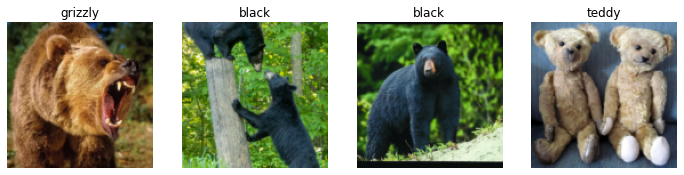

In [97]:
dls.valid.show_batch(max_n=4, nrows=1)

__Resize__

By default `Resize` *crops* the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them:

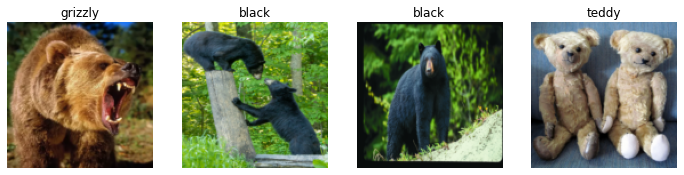

In [98]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

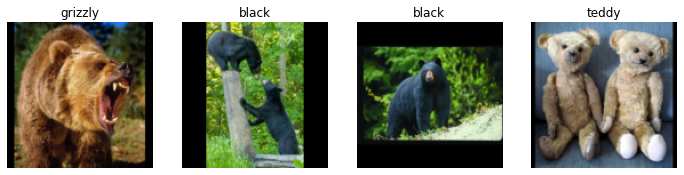

In [99]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

__RandomResizedCrop__

All of these approaches seem somewhat wasteful, or problematic.
In practice we randomly select part of the image, and crop to just that part. On each epoch (which is one complete pass through all of our images in the dataset) we randomly select a different part of each image. This means that our model can learn to focus on, and recognize, different features in our images. It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.

Training the neural network with examples of images where the objects are in slightly different places and slightly different sizes helps it to understand the basic concept of what an object is, and how it can be represented in an image.

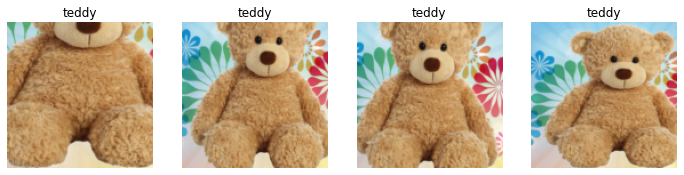

In [100]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

The most important parameter to pass in is `min_scale`, which determines how much of the image to select at minimum each time.

We used `unique=True` to have the same image repeated with different versions of this `RandomResizedCrop` transform. This is a specific example of a more general technique, called data augmentation.

### Data Augmentation

*Data augmentation* refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are **rotation, flipping, perspective warping, brightness changes and contrast changes**. 

- a standard set of augmentations that we have found work pretty well are provided with the `aug_transforms` function. 
- Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time using the `batch_tfms` parameter 

(note that we're not using `RandomResizedCrop` in this example, so you can see the differences more clearly):

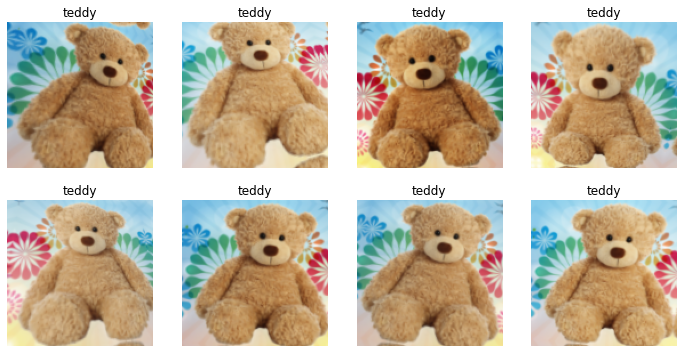

In [103]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Now that we have assembled our data in a format fit for model training, let's actually train an image classifier using it.

## Training Your Model, and Using It to Clean Your Data

We don't have a lot of data for our problem (150 pictures of each sort of bear at most), so to train our model, we'll use `RandomResizedCrop` with an image size of 224 px, which is fairly standard for image classification, and default `aug_transforms`:

In [105]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

We can now create our `Learner` and fine-tune it in the usual way. 

The `fine_tune` method trains the frozen model for `freeze_epochs`, `unfreeze`s, and trains for `epochs` using discriminative LR

In [106]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.142522,0.069808,0.010526,00:05


/media/data/anaconda3/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/media/data/anaconda3/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.144091,0.037522,0.010526,00:05
1,0.095339,0.056952,0.021053,00:05
2,0.067641,0.060374,0.021053,00:05
3,0.051824,0.056731,0.021053,00:05


/media/data/anaconda3/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/media/data/anaconda3/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/media/data/anaconda3/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/media/data/anaconda3/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/media/data/anaconda3/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/media/data/ana

Now let's see whether the mistakes the model is making are mainly thinking that grizzlies are teddies (that would be bad for safety!), or that grizzlies are black bears, or something else. To visualize this, we can create a *confusion matrix*:

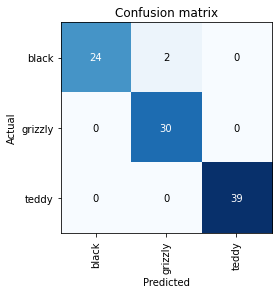

In [107]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The rows represent all the black, grizzly, and teddy bears in our dataset, respectively. The columns represent the images which the model predicted as black, grizzly, and teddy bears, respectively. Therefore, the diagonal of the matrix shows the images which were classified correctly, and the off-diagonal cells represent those which were classified incorrectly. This is one of the many ways that fastai allows you to view the results of your model. It is (of course!) calculated using the validation set. With the color-coding, the goal is to have white everywhere except the diagonal, where we want dark blue. Our bear classifier isn't making many mistakes!

It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem (e.g., images that aren't bears at all, or are labeled incorrectly, etc.), or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.). To do this, we can sort our images by their *loss*.

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. In a couple of chapters we'll learn in depth how loss is calculated and used in the training process. For now, `plot_top_losses` shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The *probability* here is the confidence level, from zero to one, that the model has assigned to its prediction:

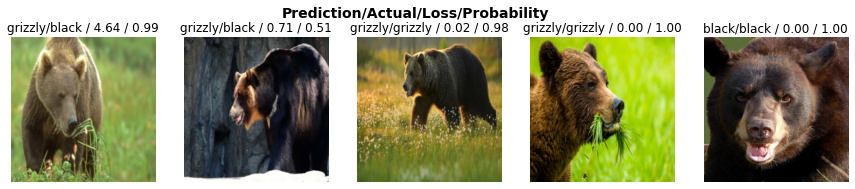

In [108]:
interp.plot_top_losses(5, nrows=1)

### Data Cleaning

The intuitive approach to doing data cleaning is to do it *before* you train a model. But as you've seen in this case, a model can actually help you find data issues more quickly and easily. So, we normally prefer to train a quick and simple model first, and then use it to help us with data cleaning.

fastai includes a handy GUI for data cleaning called `ImageClassifierCleaner` that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

In [109]:
from fastai.vision.widgets import *

In [110]:
cleaner = ImageClassifierCleaner(learn)

/media/data/anaconda3/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [42]:
cleaner

/media/data/anaconda3/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


We can see that amongst our "black bears" is an image that contains two bears: one grizzly, one black. So, we should choose `<Delete>` in the menu under this image. `ImageClassifierCleaner` doesn't actually do the deleting or changing of labels for you; it just returns the indices of items to change. So, for instance, to delete (`unlink`) all images selected for deletion, we would run:

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

To move images for which we've selected a different category, we would run:

```python
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
```

__Some Notes__

> Cleaning the data and getting it ready for your model are two of the biggest challenges for data scientists; they say it takes 90% of their time. The fastai library aims to provide tools that make it as easy as possible.

Once we've cleaned up our data, we can retrain our model. Try it yourself, and see if your accuracy improves!

> No Need for Big Data: After cleaning the dataset using these steps, we generally are seeing 100% accuracy on this task. We even see that result when we download a lot fewer images than the 150 per class we're using here. As you can see, the common complaint that _you need massive amounts of data to do deep learning_ can be a very long way from the truth!

Now that we have trained our model, let's see how we can deploy it to be used in practice.

## Turning Your Model into an Online Application

We are now going to look at what it takes to turn this model into a working (prototype) online application.

### Using the Model for Inference

Once you've got a model you're happy with, you need to save it, so that you can then copy it over to a server where you'll use it in production. Remember that a model consists of two parts: the *architecture* and the trained *parameters*. The easiest way to save the model is to save both of these, because that way when you load a model you can be sure that you have the matching architecture and parameters. To save both parts, use the `export` method.

This method even saves the definition of how to create your `DataLoaders`. This is important, because otherwise you would have to redefine how to transform your data in order to use your model in production. fastai automatically uses your validation set `DataLoader` for inference by default, so your data augmentation will not be applied, which is generally what you want.

When you call `export`, fastai will save a file called "export.pkl":

In [111]:
learn.export()

Let's check that the file exists, by using the `ls` method that fastai adds to Python's `Path` class:

In [112]:
path = Path()
path.ls(file_exts='.pkl')

(#2) [Path('bear_classifier.pkl'),Path('export.pkl')]

You'll need this file wherever you deploy your app to. For now, let's try to create a simple app within our notebook.

When we use a model for getting predictions, instead of training, we call it *inference*. To create our inference learner from the exported file, we use `load_learner` (in this case, this isn't really necessary, since we already have a working `Learner` in our notebook; we're just doing it here so you can see the whole process end-to-end):

In [113]:
learn_inf = load_learner(path/'export.pkl')

When we're doing inference, we're generally just getting predictions for one image at a time. To do this, pass a filename to `predict`:

In [114]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([3.0826e-08, 1.0000e+00, 5.0065e-11]))

This has returned three things: the predicted category in the same format you originally provided (in this case that's a string), the index of the predicted category, and the probabilities of each category. The last two are based on the order of categories in the *vocab* of the `DataLoaders`; that is, the stored list of all possible categories. At inference time, you can access the `DataLoaders` as an attribute of the `Learner`:

In [115]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

We can see here that if we index into the vocab with the integer returned by `predict` then we get back "grizzly," as expected. Also, note that if we index into the list of probabilities, we see a nearly 1.00 probability that this is a grizzly.

We know how to make predictions from our saved model, so we have everything we need to start building our app. We can do it directly in a Jupyter notebook.

### Creating a Notebook App from the Model

To use our model in an application, we can simply treat the `predict` method as a regular function. Therefore, creating an app from the model can be done using any of the myriad of frameworks and techniques available to application developers.

However, most data scientists are not familiar with the world of web application development. So let's try using something that you do, at this point, know: it turns out that we can create a complete working web application using nothing but Jupyter notebooks! The two things we need to make this happen are:

- IPython widgets (ipywidgets)
- Voilà

*IPython widgets* are GUI components that bring together JavaScript and Python functionality in a web browser, and can be created and used within a Jupyter notebook. For instance, the image cleaner that we saw earlier is entirely written with IPython widgets. However, we don't want to require users of our application to run Jupyter themselves.

That is why *Voilà* exists. Voilà is a lightweight and efficient WSGI server. It is a system for making applications consisting of IPython widgets available to end users, without them having to use Jupyter at all. Voilà is taking advantage of the fact that a notebook _already is_ a kind of web application, just a rather complex one that depends on another web application: Jupyter itself. Essentially, it helps us automatically convert the complex web application we've already implicitly made (the notebook) into a simpler, easier-to-deploy web application, which functions like a normal web application rather than like a notebook.

But we still have the advantage of developing in a notebook, so with ipywidgets, we can build up our GUI step by step. We will use this approach to create a simple image classifier. First, we need a file upload widget:

In [116]:
from fastai.vision.widgets import *

In [117]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

Now we can grab the image:

In [119]:
img = PILImage.create(btn_upload.data[-1])

We can use an `Output` widget to display it:

In [120]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

Then we can get our predictions:

In [121]:
pred,pred_idx,probs = learn_inf.predict(img)

and use a `Label` to display them:

In [122]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: teddy; Probability: 0.9997')

We'll need a button to do the classification. It looks exactly like the upload button:

In [123]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

We'll also need a *click event handler*; that is, a function that will be called when it's pressed. We can just copy over the lines of code from above:

In [124]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

You can test the button now by pressing it, and you should see the image and predictions update automatically!

We can now put them all in a vertical box (`VBox`) to complete our GUI:

In [125]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

We have written all the code necessary for our app. The next step is to convert it into something we can deploy.

### Turning Your Notebook into a Real App

Now that we have everything working in this Jupyter notebook, we can create our application. To do this, start a new notebook and add to it only the code needed to create and show the widgets that you need, and markdown for any text that you want to appear. 

__GPUs__:
As you now know, you need a GPU to train nearly any useful deep learning model. So, do you need a GPU to use that model in production? No! You almost certainly *do not need a GPU to serve your model in production*.

For at least the initial prototype of your application, and for any hobby projects that you want to show off, you can easily host them for free. The best place and the best way to do this will vary over time, so check the [book's website](https://book.fast.ai/) for the most up-to-date recommendations. One simple (and free!) approach is to use [Binder](https://mybinder.org/). To publish your web app on Binder, you follow these steps:

1. Add your notebook to a [GitHub repository](http://github.com/) (you need to add a requirements.txt file in your repo that allows Binder to install the required packages!)
2. Paste the URL of that repo into Binder's URL.
3. Change the File dropdown to instead select URL.
4. In the "URL to open" field, enter `/voila/render/name.ipynb` (replacing `name` with the name of for your notebook).
5. Click the clickboard button at the bottom right to copyt the URL and paste it somewhere safe. 
6. Click Launch.

<img alt="Deploying to Binder" width="800" caption="Deploying to Binder" id="deploy-binder" src="https://raw.githubusercontent.com/fastai/fastbook/master/images/att_00001.png">

The first time you do this, Binder will take around 5 minutes to build your site. Behind the scenes, it is finding a virtual machine that can run your app, allocating storage, collecting the files needed for Jupyter, for your notebook, and for presenting your notebook as a web application.

Here you find the Bear App from today's lesson: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/pds2021/course/HEAD?urlpath=%2Fvoila%2Frender%2Fnbs%2F07_Bear_App.ipynb)